In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,GRU, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

text = None

### Preprocessing

In [47]:
seq_length = 20
step = 1
embedding_dim = 48
units = 96

with open('/kaggle/input/dinosaur-island/dinos.txt', 'r') as file:
    text = file.read()
    
chars = sorted(set(text))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(f"Total unique characters: {vocab_size}")

sequences = []
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sequences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])

print(f"Total sequences: {len(sequences)}")

# Integer-encoded inputs:
X_int = np.zeros((len(sequences), seq_length), dtype=np.int32)
for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X_int[i, t] = char_to_idx[char]

# One-hot encode outputs (targets)
y = np.zeros((len(sequences), vocab_size), dtype=np.bool_)
for i, char in enumerate(next_chars):
    y[i, char_to_idx[char]] = 1

Total unique characters: 53
Total sequences: 19889


In [48]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length),
    GRU(units, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation='softmax')
])

# If needed, force a build (uncomment if necessary):
model.build(input_shape=(None, seq_length))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    # optimizer=RMSprop(learning_rate=0.0005), 
    metrics=['accuracy']
)

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 20, 48)              │           2,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_20 (GRU)                         │ (None, 96)                  │          42,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 53)                  │           5,141 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,733 (194.27 KB)

 Trainable params: 49,733 (194.27 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(X_int, y, batch_size=128, epochs=50, callbacks=[early_stop])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.1740 - loss: 3.2589
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3871 - loss: 2.1400
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4196 - loss: 1.9371
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4332 - loss: 1.8785
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4505 - loss: 1.8000
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4691 - loss: 1.7732
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4730 - loss: 1.7437
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4944 - loss: 1.6853
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4994 - loss: 1.6456
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5107 - loss: 1.6172
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5165 - loss: 1.6006
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 

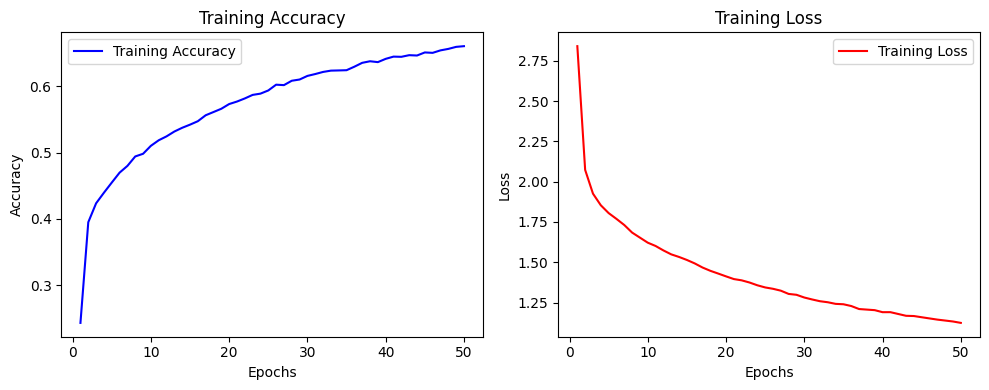

In [50]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

In [51]:
import numpy as np

def sample(preds, temperature=1.0):
    """
    Samples an index from a probability array after applying temperature scaling.
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature  # temperature scaling
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(preds)), p=preds)

def generate_name(seed="A", length=30, temperature=0.8):
    """
    Generates text from the model given a seed string.
    This function converts the seed into integer encoding, pads it if necessary,
    and generates subsequent characters using the updated model.
    
    Args:
      seed (str): starting string for generation.
      length (int): maximum number of additional characters to generate.
      temperature (float): sampling temperature.
    
    Returns:
      str: the generated text with the seed.
    """
    generated = seed

    # If the seed is shorter than the sequence length, pad on the left with newlines.
    if len(generated) < seq_length:
        pad = "\n" * (seq_length - len(generated))
        generated = pad + generated
    
    for i in range(length):
        # Get the last seq_length characters as the current input.
        input_seq = generated[-seq_length:]
        # Convert characters to integer indices using your char_to_idx mapping.
        input_encoded = [char_to_idx[c] for c in input_seq]
        # Reshape to (1, seq_length) for the model.
        x_pred = np.array(input_encoded)[np.newaxis, :]

        # Get prediction probabilities from the model.
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]
        generated += next_char

        # Stop generating if a newline is generated.
        if next_char == "\n":
            break

    return generated.strip()


In [55]:
# Generate 10 sample names
for _ in range(10):
    print(generate_name(seed="c", length=30, temperature=0.8))

cepatasaurus
cPawasaurus
cpentasaurus
cohnitlosaurus
culanosaurus
celavenator
cQenagama
cTaratosaurus
cBpeltitan
cophisaurus
